In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_augmented_transactions.csv to synthetic_augmented_transactions.csv


In [3]:
df = pd.read_csv('synthetic_augmented_transactions.csv')
df.head()

,Amount,DeviceID,ReturnCount,CouponUsed,HourOfDay,DayOfWeek,Month,TimeSinceLastTransaction,TransactionsInLastHour,AmountInLastHour,CustomerAge,ProductPrice,CustomerLocation,ProductCategory,IsFraud
0,3749.080238,desktop,7,0,23,4,5,9.361118,5,5299.924747,28,4732.352292,Mexico,Home & Garden,1
1,4416.145156,mobile,9,0,2,3,6,0.046726,6,5550.213530,29,4223.306321,US,Home & Garden,1
2,3046.124850,tablet,7,0,3,1,12,58.425331,5,6368.209953,20,3764.923983,Mexico,Home & Garden,1
3,3933.525786,desktop,7,0,3,4,9,3.903096,6,7826.605267,19,3770.833005,Canada,Groceries,1
4,3461.787651,tablet,8,0,3,3,8,2.063311,4,6173.181823,19,4325.044569,Canada,Electronics,1


IsFraud
1    0.5
0    0.5
Name: proportion, dtype: float64


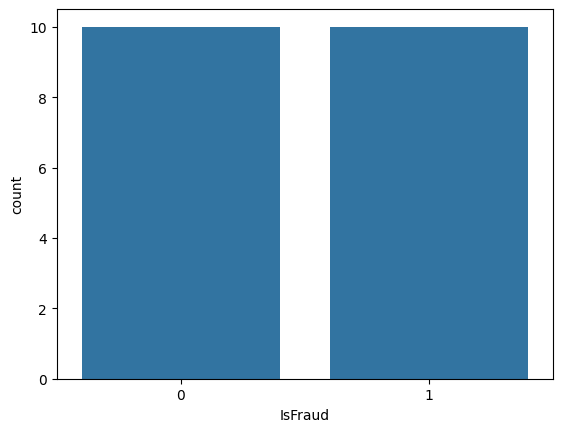

In [4]:
print(df['IsFraud'].value_counts(normalize=True))
sns.countplot(x='IsFraud', data=df);

In [5]:

X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

categorical_cols = X.select_dtypes(include=['object']).columns

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

joblib.dump(rf, 'balanced_rf_model.joblib')

['balanced_rf_model.joblib']

In [6]:
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



Here's the advantage we can adjust the Threshold as we want..

In [7]:
y_proba = rf.predict_proba(X_test)[:, 1]
threshold = 0.2
y_pred_thresh = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# **Check Points :**

In [8]:
print("Type of rf:", type(rf))

Type of rf: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [10]:
print("Type of X_test:", type(X_test))

Type of X_test: <class 'pandas.core.frame.DataFrame'>


In [11]:
print(hasattr(rf, "predict_proba"))

True


In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [15]:
print("shap_values[1] shape:", shap_values[1].shape)
print("X_test shape:", X_test.shape)
print("X_train shape:", X_train.shape)
print("X_train columns:", list(X_train.columns))
print("X_test columns:", list(X_test.columns))

shap_values[1] shape: (19, 2)
X_test shape: (4, 19)
X_train shape: (16, 19)
X_train columns: ['Amount', 'ReturnCount', 'CouponUsed', 'HourOfDay', 'DayOfWeek', 'Month', 'TimeSinceLastTransaction', 'TransactionsInLastHour', 'AmountInLastHour', 'CustomerAge', 'ProductPrice', 'DeviceID_mobile', 'DeviceID_tablet', 'CustomerLocation_Mexico', 'CustomerLocation_UK', 'CustomerLocation_US', 'ProductCategory_Electronics', 'ProductCategory_Groceries', 'ProductCategory_Home & Garden']
X_test columns: ['Amount', 'ReturnCount', 'CouponUsed', 'HourOfDay', 'DayOfWeek', 'Month', 'TimeSinceLastTransaction', 'TransactionsInLastHour', 'AmountInLastHour', 'CustomerAge', 'ProductPrice', 'DeviceID_mobile', 'DeviceID_tablet', 'CustomerLocation_Mexico', 'CustomerLocation_UK', 'CustomerLocation_US', 'ProductCategory_Electronics', 'ProductCategory_Groceries', 'ProductCategory_Home & Garden']


In [16]:
from sklearn.ensemble import RandomForestClassifier
import shap
import pandas as pd

# Refit model to ensure correctness
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Type of rf:", type(rf))


Type of rf: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [17]:
X_test_reordered = X_test[X_train.columns]

print("X_test_reordered shape:", X_test_reordered.shape)
print("X_train shape:", X_train.shape)

X_test_reordered shape: (4, 19)
X_train shape: (16, 19)


In [18]:
explainer = shap.TreeExplainer(rf)

X_small = X_test_reordered.iloc[:10]

shap_values = explainer.shap_values(X_small)
print("shap_values[0] shape:", shap_values[0].shape)
print("shap_values[1] shape:", shap_values[1].shape)


shap_values[0] shape: (19, 2)
shap_values[1] shape: (19, 2)


In [19]:
# checking all class seen by the model:
print("Classes seen by model:", rf.classes_)


Classes seen by model: [0 1]


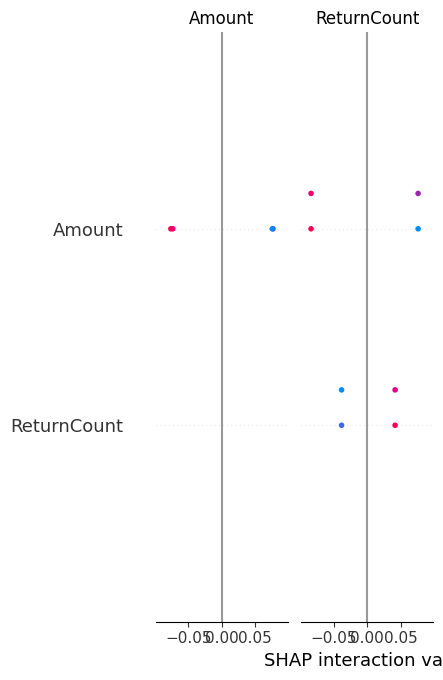

In [20]:
shap_values = explainer.shap_values(X_small)
shap.summary_plot(shap_values, X_small)


In [21]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [22]:
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

st.set_page_config(layout="wide") # Use wide layout

st.title('Walmart Fraud Detection App')
st.write('Analyze transaction data and predict fraud using a trained model.')

# Load data and model
@st.cache_resource # Cache the data loading
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        st.error(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return None

@st.cache_resource # Cache the model loading
def load_model(file_path):
    try:
        model = joblib.load(file_path)
        return model
    except FileNotFoundError:
        st.error(f"Error: Model file not found at {file_path}")
        return None
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

df = load_data('synthetic_augmented_transactions.csv')
model = load_model('balanced_rf_model.joblib')

if df is None or model is None:
    st.stop() # Stop the app if data or model failed to load


# ⬆️ Upload New Data
st.sidebar.header("Upload Your Data")
uploaded_file = st.sidebar.file_uploader("Upload a CSV file", type=["csv"])

if uploaded_file is not None:
    df = load_data(uploaded_file)
    if df is not None:
        st.sidebar.success("Custom data loaded successfully!")
    else:
        st.sidebar.error("Failed to load custom data.")
        st.stop() # Stop if custom data load fails


# 📊 Data Analysis and Visualizations
st.header("Data Analysis and Visualizations")

st.subheader("Sample Data")
st.dataframe(df.head())

st.subheader("Data Summary")
st.write(df.describe())

st.subheader("Distribution of Features")

# Use columns for better layout
col1, col2 = st.columns(2)

numerical_cols = ['Amount', 'ReturnCount', 'HourOfDay', 'DayOfWeek', 'Month', 'TimeSinceLastTransaction', 'TransactionsInLastHour', 'AmountInLastHour', 'CustomerAge', 'ProductPrice']
categorical_cols = ['DeviceID', 'CustomerLocation', 'ProductCategory']

with col1:
    st.write("Numerical Feature Distributions")
    for col in numerical_cols:
        fig, ax = plt.subplots()
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        st.pyplot(fig)
        plt.close(fig)

with col2:
    st.write("Categorical Feature Distributions")
    for col in categorical_cols:
        fig, ax = plt.subplots()
        sns.countplot(y=col, data=df, ax=ax, order = df[col].value_counts().index)
        ax.set_title(f'Count of {col}')
        st.pyplot(fig)
        plt.close(fig)

st.subheader("Fraud Distribution")
fig, ax = plt.subplots()
sns.countplot(x='IsFraud', data=df, ax=ax)
ax.set_title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
st.pyplot(fig)
plt.close(fig)

#  Fraud Prediction
st.header("Fraud Prediction")

st.write("Enter transaction details to predict if it's fraudulent.")

# Use columns for input fields
input_cols = st.columns(3)

# Create input fields for features
with input_cols[0]:
    amount = st.number_input('Amount', min_value=0.0, value=float(df['Amount'].mean()), format="%.2f")
    return_count = st.number_input('ReturnCount', min_value=0, value=int(df['ReturnCount'].mean()))
    coupon_used = st.selectbox('CouponUsed', [0, 1])
    hour_of_day = st.number_input('HourOfDay', min_value=0, max_value=23, value=int(df['HourOfDay'].mean()))
    day_of_week = st.number_input('DayOfWeek', min_value=0, max_value=6, value=int(df['DayOfWeek'].mean()))

with input_cols[1]:
    month = st.number_input('Month', min_value=1, max_value=12, value=int(df['Month'].mean()))
    time_since_last_transaction = st.number_input('TimeSinceLastTransaction', min_value=0.0, value=float(df['TimeSinceLastTransaction'].mean()), format="%.2f")
    transactions_in_last_hour = st.number_input('TransactionsInLastHour', min_value=0, value=int(df['TransactionsInLastHour'].mean()))
    amount_in_last_hour = st.number_input('AmountInLastHour', min_value=0.0, value=float(df['AmountInLastHour'].mean()), format="%.2f")
    customer_age = st.number_input('CustomerAge', min_value=0, value=int(df['CustomerAge'].mean()))

with input_cols[2]:
    product_price = st.number_input('ProductPrice', min_value=0.0, value=float(df['ProductPrice'].mean()), format="%.2f")
    device_id = st.selectbox('DeviceID', df['DeviceID'].unique())
    customer_location = st.selectbox('CustomerLocation', df['CustomerLocation'].unique())
    product_category = st.selectbox('ProductCategory', df['ProductCategory'].unique())

# Add interactive threshold slider
st.sidebar.header("Prediction Threshold")
threshold = st.sidebar.slider("Select Probability Threshold for Fraud", 0.0, 1.0, 0.5, 0.01) # Default to 0.5, step 0.01

# Prediction button
if st.button('Predict Fraud'):
    # Create a DataFrame from user input
    input_data = pd.DataFrame({
        'Amount': [amount],
        'DeviceID': [device_id],
        'ReturnCount': [return_count],
        'CouponUsed': [coupon_used],
        'HourOfDay': [hour_of_day],
        'DayOfWeek': [day_of_week],
        'Month': [month],
        'TimeSinceLastTransaction': [time_since_last_transaction],
        'TransactionsInLastHour': [transactions_in_last_hour],
        'AmountInLastHour': [amount_in_last_hour],
        'CustomerAge': [customer_age],
        'ProductPrice': [product_price],
        'CustomerLocation': [customer_location],
        'ProductCategory': [product_category]
    })

    # One-hot encode categorical features - ensure consistency with training data
    categorical_cols = ['DeviceID', 'CustomerLocation', 'ProductCategory']
    input_data_encoded = pd.get_dummies(input_data, columns=categorical_cols, drop_first=True)

    # Ensure the input data has the same columns as the training data used for the model
    # Get the columns from the training data by encoding the original df (excluding target)
    df_encoded_cols = pd.get_dummies(df.drop('IsFraud', axis=1), columns=categorical_cols, drop_first=True).columns

    # Reindex the input data to match the model's expected column order and fill missing columns with 0
    input_data_aligned = input_data_encoded.reindex(columns=df_encoded_cols, fill_value=0)

    # Make prediction
    prediction_proba = model.predict_proba(input_data_aligned)[:, 1]

    # Classify based on the interactive threshold
    prediction = (prediction_proba >= threshold).astype(int)


    # Display prediction result
    st.subheader("Prediction Result")
    if prediction[0] == 1:
        st.error(f"This transaction is predicted as **Fraudulent** (Probability: {prediction_proba[0]:.4f} >= Threshold: {threshold})")
    else:
        st.success(f"This transaction is predicted as **Non-Fraudulent** (Probability: {prediction_proba[0]:.4f} < Threshold: {threshold})")



2025-07-08 07:07:36.111 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-08 07:07:36.112 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-08 07:07:36.211 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-08 07:07:36.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-08 07:07:36.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-08 07:07:36.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-08 07:07:36.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn